In [1]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statsmodels.formula.api as smf
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import het_breuschpagan #Heteroskedasticity test
from statsmodels.stats.diagnostic import het_white #Heteroskedasticity test
from sklearn.metrics import confusion_matrix

#Probabilistic programs
#!pip install numpy mkl #if you are in an intel machine i.e. in mac M# chips no
#!pip install pymc
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs 
#IMPORTANT: properly install ipywidgets and nodejs for interactive graphs
#If you are in jupyterlab, activate the widget extension (it should be in the latest versions)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from mpl_toolkits.mplot3d import axes3d
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.3


In [2]:
def f(k,robust = False): #Esta función tiene comandos para la regresión y para gráficas.
    #k: heterosdactity parameter...larger more heteroscedasticity
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    #Noise here depends on the level of the variable X
    Y_noise = np.random.normal(loc = 0, scale = X_data**k, size = n)
    Y = pd.DataFrame({"X": X_data, "Y": Y_raw + Y_noise})
    
    # Regression
    model = smf.ols(formula='Y ~ X', data = Y)
    if robust == True:
        results = model.fit(cov_type='HC3') #robust standard errors (to heteroskedasticity)
    else:
        results = model.fit() 
    residuals = results.resid
    Y['predictions'] = results.predict(Y['X'])
    white_test = het_white(residuals,  model.exog)
    bp_test = het_breuschpagan(residuals, model.exog)
    
    
    #Gráficas
    sns.scatterplot(x = 'X', y='Y', data=Y, color = 'black', ax = axes[0])
    axes[0].set_title("Heteroskedasticity \n Variance in y depends on x level")
    axes[0].plot(Y['X'], Y['predictions'], color = 'red')
    axes[1].axis('off')
    const = str(round(results.params[0],3))
    slope = str(round(results.params[1],3))
    axes[1].text(0, 0.5, 'Truth: Intercept: 1.370; Coef. X: 2.097 \nRegres: Intercept: ' + const + '; Coef. X: ' + slope,
        color='black', fontsize=15)
    
    #Output
    plt.show()
    print(results.summary()) 
    print("Durbin Watson measures autocorrelation of residuals. Close to 2 is good, zero autocorrelations")
    print("Jarque Bera is a test of normality of the residuals for large samples (n>2000). Large values and p<0.05 not normal")
    labels = ['LM-Statistic','LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("Breusch Pagan test (p<0.05 there is Heteroskedasticity): ", dict(zip(labels[2:4], bp_test[2:4]))) # p<0.05 hay heterocedasticidad
    print("White test (p<0.05 there is Heteroskedasticity): ", dict(zip(labels[2:4], white_test[2:4]))) # p<0.05 hay heterocedasticidad
    
    plt.figure()
    fig =  sm.graphics.plot_regress_exog(results, "X")
    fig.tight_layout(pad=1.0)
    


# Residuals and heteroskedasticity visualization.

It can bias the estimates as shown below. Change k and use robust std. error. Note how the normality, autocorrelation, and heteroskedasticity tests change. Also, the residuals visualizations.

In [3]:
n = 2000
X_data = np.linspace(1,100, n)
Y_raw = 1.37 + 2.097 * X_data #The underlying truth ... the majority of the times is unknown...here for pedagogical reasons we do know it

interact(f, k = widgets.FloatSlider(min=0, max=3, step=.2, value=1.25), 
         robust = widgets.Checkbox(value = False, description = 'Robust std. err.')); #Larger k more heteroskedasticity


interactive(children=(FloatSlider(value=1.25, description='k', max=3.0, step=0.2), Checkbox(value=False, descr…

# Running regressions in Python (and R to some extent)

C:\Users\L03552670\AppData\Local\Temp\ipykernel_45292\4252004709.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_r.replace({'Gender': {1: "Male", 2: "Female"}}, inplace = True)
C:\Users\L03552670\AppData\Local\Temp\ipykernel_45292\4252004709.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_r.replace({'Shop_Behavior': {1: "Physical", 2: "Online", 3: "Both"}}, inplace = True)


                            OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     60.92
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           2.57e-33
Time:                        19:32:46   Log-Likelihood:                -231.38
No. Observations:                 200   AIC:                             472.8
Df Residuals:                     195   BIC:                             489.2
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

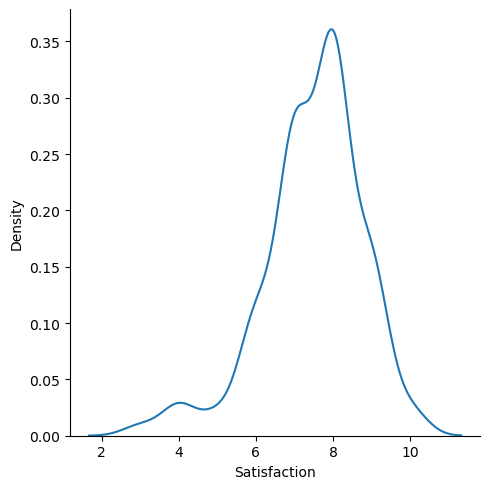

<Figure size 640x480 with 0 Axes>

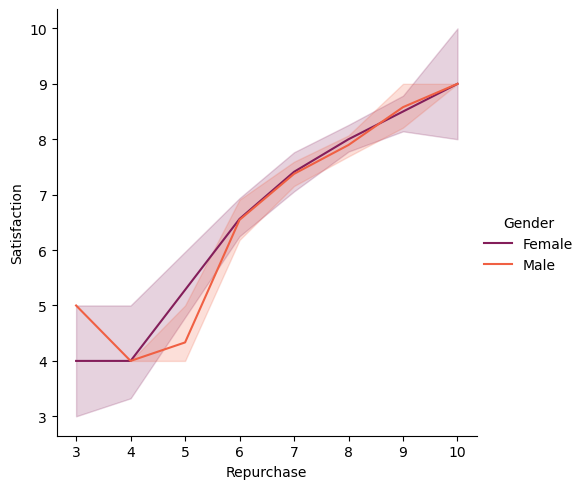

<Figure size 640x480 with 0 Axes>

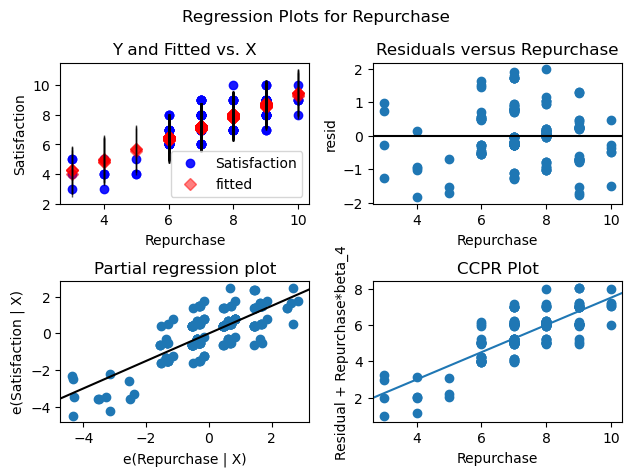

In [4]:
#Load data
#SOURCE: Harvard Business Publishing (SMU557)
#"Amazon: Facing low costumer satisfaction in Singapore"
#By: Marcus Ang Teck and Chen Yongchang, Singapore Management University
amazon = pd.read_csv("Amazon_Satisfaction_Singapore.csv")
amazon_var_dictionary = pd.read_csv("Amazon_Satisfaction_Singapore_Var_Dictionary.csv") #Description of variables

#Filter for only Amazon
amazon_r = amazon.query("company_v=='AMAZON'")

#Description of variables.
#Rename columns for something more informative
cols = ["ID", #Consumer
        "Company", #Seller name
        "Prod_Quality", #Overall Product Quality 1 Very low, 10 Very High
        "Service_Quality", #Overall Service Quality 
        "Price_Value", #Price given quality 1 Very poor price,  10 Very good price
        "Satisfaction", #Customer Satisfaction 1 Very dissatisfied, 10 Very satisfied
        "Repurchase", #Likelihood to Repurchase 1 Very unlikely, 10 Very likely
        "Recommend", #Likelihood to recommend
        "Recommend_Site", #Recommended ecommerce site to family and friends in the last 3 months  0 No, 1 Yes
        "Satisfaction_With", #Overall experiences SATISFACTION with (INSERT NAME) 1 Very dissatisfied, 10 Very satisfied
        "Variety_Prods", #Variety of products that interests me
        "Variety_Prods_Needs", #Variety of products that meet my needs
        "Ease_Navigation", #Ease of navigating the website or app
        "Ease_Prods_Needs", #Ease of finding the products you need
        "Availability_Prods", #Availability of products
        "Discounts", #Attractiveness of promotions and discounts offered
        "Info_Prods", #Sufficiency of Product information
        "Ease_Comparing", #Ease of comparing products
        "Ease_Special_Needs", #Ease of indicating special requests
        "Ease_Cart", #Ease of managing your shopping cart
        "Ease_Check_Out", #Check-out and payment process
        "Security", #Security of website
        "Delivery", #Clarity and usefulness of information on your delivery methods and fees
        "Delivery_Range", #Range of delivery options
        "Order_Tracking", #Ease of tracking your order
        "Delivery_Time", #Time taken to receive the product
        "Fidelity_Prods", #Products you received were as described on the website
        "Feedback", #Availability of feedback channels
        "Return_Policies", #Return and exchange policies
        "Channel_Pref", #Method Used most frequently to shop at (INSERT NAME) 1 Mobile App, 2 Website (Using PC), 3 Website (Using a mobile device)
        "Pay_Pref", #Method of payment do you prefer most for shopping online at (INSERT NAME) 1 Credit Cards, 2 PayPal, 3 E-nets, 4 AXS machines, 5 Cash upon delivery, 6 Others
        "Pay_Pref_Other", #Method of payment do you prefer most for shopping online at (INSERT NAME) Other specify
        "Read_Reviews", #Read the reviews during shopping experience 1 Yes 2 No
        "Interacted_Seller", #Interacted directly with the seller during shopping experience
        "Satisfaction_Reviews", #Satisfaction with the product reviews 1 Very dissatisfied, 10 Very satisfied
        "Satisfaction_Channels_Seller", #Satisfaction with the channels available to communicate with the seller(s)
        "No_Purchases_6m", #No. of times purchased in the last 6 months
        "Amount_Spent_3m", #Average amount spent per visit last 3 months
        "Shop_Behavior", #General Shopping Behavior: Usually make most purchases on physical store or an online store 1 Physical store, 2 Online store 3 Equal for both physical store &  online store
        "Age", #Age
        "Race", #Race of the respondent 1 Chinese, 2 Malay, 3 Indian, 4 Eurasian, 5 Others
        "Employment", #Employment status of the respondent 1 Working full-time, 2 Working part-time, 3 Homemaker, 4 Retired, 5 Student, 6 Unemployed
        "Income_Personal", #Monthly Personal Income "1	Under SGD 2K; 2 SGD 2K - Under SGD 3K; 3 SGD 3K - Under SGD 4K; 4	SGD 4K - Under SGD 6K; 5	SGD 6K - Under SGD 8K: 6	SGD 8K - Under SGD 10K; 7	SGD 10K - Under SGD 15K; 8	SGD 15K - Under SGD 20K; 9	SGD 20K or over"
        "Income_House", #Monthly Household Income
        "Ed", #Education Qualification "1	None; 2	PSLE & below; 3	GCE N Level; 4	GCE O Level; 5	GCE A Level / Post-Secondary; 6	ITE / Vocational Institute; 7	Polytechnic Diploma / Professional Cert; 8	University Degree; 9	University Post-Graduate Degree"
        "No_Children", #No. of children dependent for financial support
        "Marital", #Marital Status "1	Single; 2	Married; 3	Divorced; 4	Widowed; 5	Separated;6	Domestic Partnership"
        "Gender", #Gender "1	Male; 2	Female"
        "House_Type", #Housetype according to respondent "1	HDB 1-2 room; 2	HDB 3 room; 3	HDB 4 room; 4	HDB 5 room / Executive Flat; 5	Condo / Ptd Apartment; 6	Landed Property"
        "Date_Interview", #Date of Interview
       ]
amazon_r.columns = cols

#Some EDA plots
amazon_r.replace({'Gender': {1: "Male", 2: "Female"}}, inplace = True)
amazon_r.replace({'Shop_Behavior': {1: "Physical", 2: "Online", 3: "Both"}}, inplace = True)
#Distribution of the DV: satisfaction
#sns.catplot(data = amazon_r, y = "Satisfaction" , kind = "box")
sns.displot(amazon_r, x = "Satisfaction", kind = "kde");
plt.figure();
sns.relplot(amazon_r, x = "Repurchase", y = "Satisfaction", hue = "Gender",
           palette = sns.color_palette("rocket",
                                        n_colors = amazon_r.Gender.unique().shape[0]),
           kind = "line")


#Now the regression
model = smf.ols(formula='Satisfaction ~ Repurchase + Shop_Behavior + Gender', data = amazon_r)
results = model.fit(cov_type='HC3') #robust standard errors (to heteroskedasticity)
residuals = results.resid
white_test = het_white(residuals,  model.exog)
bp_test = het_breuschpagan(residuals, model.exog)
    

#Output
print(results.summary()) 
print("Durbin Watson measures autocorrelation of residuals. Close to 2 is good, zero autocorrelations")
print("Jarque Bera is a test of normality of the residuals for large samples (n>2000). Large values and p<0.05 not normal")
labels = ['LM-Statistic','LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch Pagan test (p<0.05 there is Heteroskedasticity): ", dict(zip(labels[2:4], bp_test[2:4]))) # p<0.05 hay heterocedasticidad
print("White test (p<0.05 there is Heteroskedasticity): ", dict(zip(labels[2:4], white_test[2:4]))) # p<0.05 hay heterocedasticidad

plt.figure()
#fig =  sm.graphics.plot_regress_exog(results, "Gender[T.Male]")
fig =  sm.graphics.plot_regress_exog(results, "Repurchase")
fig.tight_layout(pad=1.0)

### Exercise (Formulas + Regression)
1) Use the previous amazon_r data
2) print data types of amazon_r
3) Plot variables or cross of variables you feel are relevant. Pick plot types that reveal the variable(s) distribution. Interpret.
4) Understand the formulae of python (and r). What is the difference between : and \*. What is the formula you get with x\*y\*z
5) Run a regression of your liking with interactions. Interpret the autocorrelation and normality tests from .summary()
6) According to the Heteroskedasticity test. Do you need robust std. errors?
7) Plot the residuals of one of the right hand variables of your regression.
8) Interpret the regression coefficients


# Trou Normand: Bayesian Regression

Also check the package [Bambi](https://bambinos.github.io/bambi/)

In a traditional regression, we infer the parameters of normal that changes mean according to the values of variables X (assumption, the standard deviation of the normal is fixed):

<center><img src="5_CB/Kruschke3.svg" width = "401" height = '400'></center>


$$ y|\beta, \sigma, X \sim Normal(X \beta,\sigma I)$$
$I$ identity; we assume homocedasticity.

The unique thing with bayes is that we can infer $\beta$ and $\sigma$ with `uncertainty`

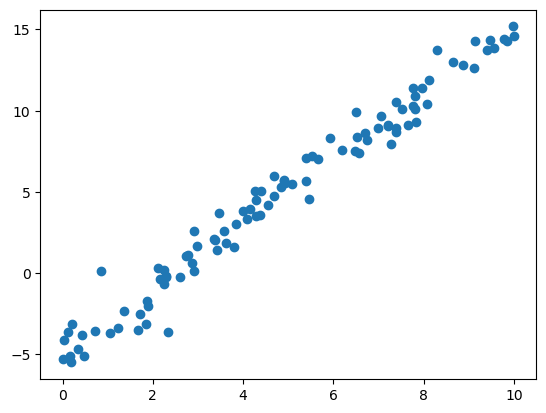

In [5]:
n = 100
x = np.random.uniform(0,10,n)
y = 2 * x - 5 + np.random.normal(0,1,n)
plt.scatter(x, y);

In [6]:
with pm.Model() as basic_model:

    #Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=3)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha + beta*x
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sigma=sigma, observed=y)
    
    # Samples
    trace = pm.sample(draws=3000, idata_kwargs = {'log_likelihood': True}) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 78 seconds.


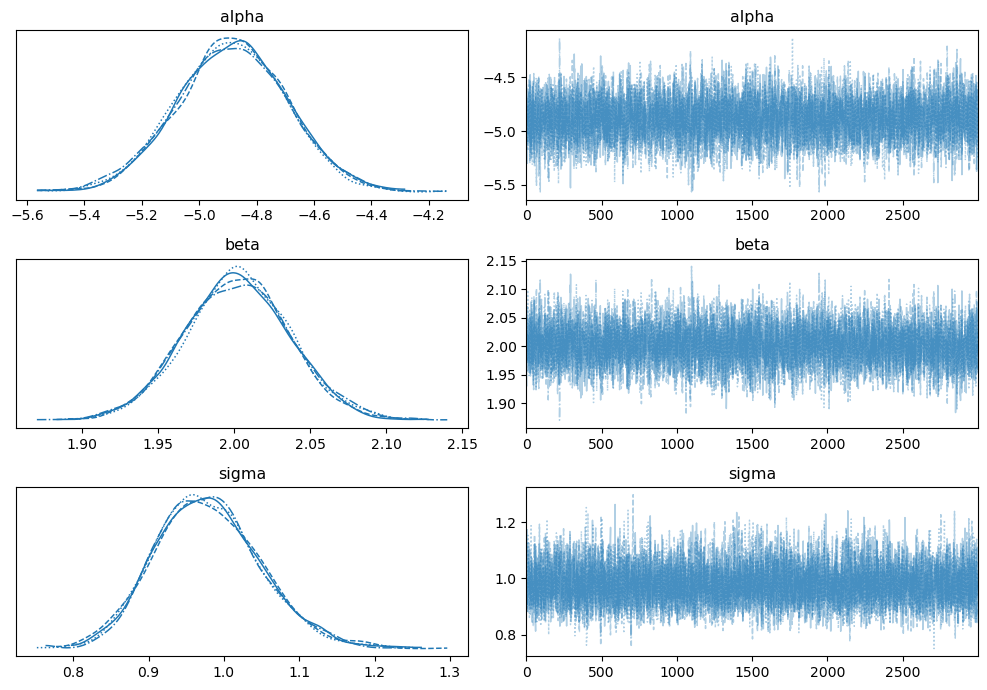

In [7]:
#Convergence
az.plot_trace(trace, figsize = [10,7]);
plt.tight_layout()
#plt.savefig("img/5_CB/trace_regression.svg"); plt.close()
#az.rhat(data) #Si es <1.1 está bien

In [8]:
with basic_model:
    print(pm.summary(trace).round(2))
    #pm.plots.forestplot(trace)

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -4.88  0.19   -5.25    -4.53        0.0      0.0    5231.0    5849.0   
beta   2.00  0.03    1.94     2.07        0.0      0.0    5342.0    5923.0   
sigma  0.98  0.07    0.84     1.11        0.0      0.0    7476.0    6877.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


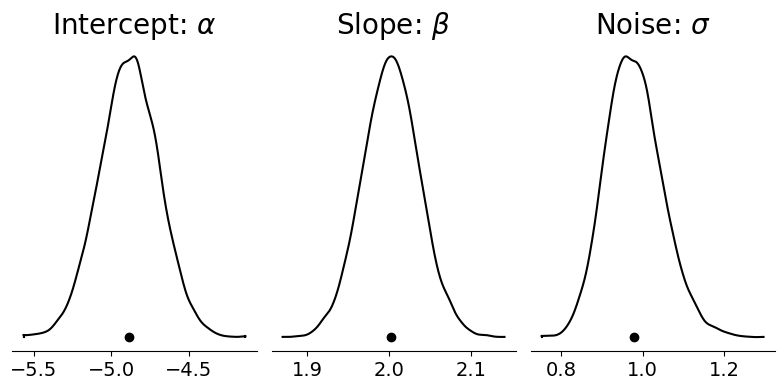

In [9]:
alpha_post = np.array(trace.posterior.alpha).flatten()
beta_post = np.array(trace.posterior.beta).flatten()
sigma_post = np.array(trace.posterior.sigma).flatten()
fig, ax = plt.subplots(1,3, figsize=(8,4))
az.plot_density(alpha_post, 
                ax = ax[0], colors = 'k',hdi_prob=1)
ax[0].set_title(r'Intercept: $\alpha$', fontsize = 20)
az.plot_density(beta_post, 
                ax = ax[1], colors = 'k', hdi_prob=1)
ax[1].set_title(r'Slope: $\beta$', fontsize = 20)
az.plot_density(sigma_post, 
                ax = ax[2], colors = 'k', hdi_prob=1)
ax[2].set_title(r'Noise: $\sigma$', fontsize = 20);
plt.tight_layout()
#plt.savefig("img/5_CB/density_regression.svg"); plt.close()

Is it a good model?. Let's start with posterior predictive checks (i.e. simulate new data). We can use the mean of $y$ in the data to compare.

In [11]:
with basic_model:
    ypred = pm.sampling.sample_posterior_predictive(trace=trace)
    sh = ypred.posterior_predictive.Ylikelihood.shape
    y_sample_posterior_predictive = np.reshape(np.array(ypred.posterior_predictive.Ylikelihood), 
                                              (sh[0]*sh[1],sh[2]))

Sampling: [Ylikelihood]


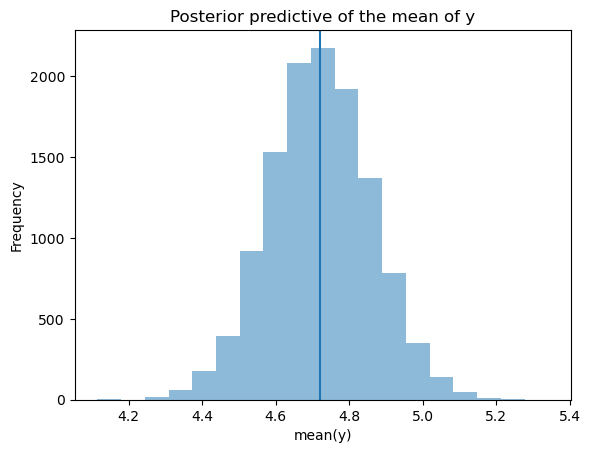

In [12]:
_, ax = plt.subplots()
ax.hist([n.mean() for n in y_sample_posterior_predictive], bins=19, alpha=0.5)
ax.axvline(y.mean()) #actual data
ax.set(title='Posterior predictive of the mean of y', xlabel='mean(y)', ylabel='Frequency');

The posterior predictive check replicates and important stat: the mean of y.

Now let's compare with WAIC the regression with a null regression (just an intercept)

In [13]:
with pm.Model() as null_model:
    #Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=4)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha 
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sigma=sigma, observed=y)
    
    # Samples
    trace_null = pm.sample(draws=3000,  idata_kwargs = {'log_likelihood': True}) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 60 seconds.


In [14]:
with null_model:
    print(pm.summary(trace_null).round(2))

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  4.71  0.58    3.62     5.79        0.0      0.0   11626.0    8502.0   
sigma  5.81  0.41    5.08     6.59        0.0      0.0   11897.0    8852.0   

       r_hat  
alpha    1.0  
sigma    1.0  


In [15]:
az.compare({'Base': trace, 'Null': trace_null}, ic = 'loo')
    

C:\Users\L03552670\anaconda3\envs\PyMC_env\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
C:\Users\L03552670\anaconda3\envs\PyMC_env\Lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Base,0,-141.084199,3.695554,0.000000,0.992877,9.912255,0.000000,False,log
Null,1,-318.964799,1.464657,177.880599,0.007123,4.956115,10.800183,False,log


# Logistic Regression

James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An
introduction to statistical learning: With applications in python. Springer
Nature

In [ ]:
#Load data
#"This data set consists of percentage returns for the S&P 500 stock
#index over 1,250 days, from the beginning of 2001 until the end of 2005.
#For each date, we have recorded the percentage returns for each of the five
#previous trading days, Lag1 through Lag5. We have also recorded Volume
#(the number of shares traded on the previous day, in billions), Today (the
#percentage return on the date in question) and Direction (whether the
#market was Up or Down on this date)." James, et al, (2023)

Smarket = pd.read_csv("Smarket.csv")
Smarket.insert(Smarket.shape[1], "Direction_Original", Smarket.Direction)
Smarket.replace({'Direction': {"Up":1, "Down":0}}, inplace = True)
print(Smarket.columns)

#Some EDA
print("The strongest correlation seems between Year and Volume\n", 
      Smarket.corr(numeric_only=True))
Smarket.plot(y='Volume')


In [ ]:
#Now a regression of Direction with Lags and Volume
glm = smf.glm("Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", 
              family=sm.families.Binomial(), #default link function is logit 
              data=Smarket).fit(cov_type='HC3')
print("Nothing significant")
print(glm.summary())
probs = glm.predict() #Default: using the info on each row of the data
print(probs.shape) 
sns.displot(probs, kind = "hist")
#If specific values:
df_to_pred = pd.DataFrame.from_dict({"Lag1":[1,2], "Lag2":[0,2], "Lag3":[2,2], "Lag4":[3,2], "Lag5":[-1,2], "Volume":[1,2]})
print("\nSome predictions (see code for X values):") 
print(glm.predict(df_to_pred))

#Predict up or down if probs>0.5
labels = np.array(['Down']*probs.shape[0]) #initialize labels
labels[probs >0.5] = "Up" #change "Down" to "Up" if condition holds

CM = pd.DataFrame(confusion_matrix(labels , Smarket.Direction_Original),
                  index = ["Down_Pred", "Up_Pred"], columns = ["Down_Real", "Up_Real"])
OA = (CM.iloc[0,0] + CM.iloc[1,1])/labels.shape[0] #overall accuracy
print("\nConfussion Matrix",
      "\nOverall Accuracy (sum diagonal/total):", OA,
      "\nIt did well for UP, not so much for DOWN:")
print(CM)

Bad practice: we trained and tested with the same data. 

Let's break the data into train and test sets. That is, we ran the logistic regression with a subset of the data (train) and predict for the remaning (test)

In [ ]:
#Train set. One way is to choose randomly.
#However, perhaps we want to see if the past predicts the future. 
#Let's train with data before year 2005.
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

#Train
glm_train = smf.glm("Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", 
                    family=sm.families.Binomial(), #default link function is logit 
                    data=Smarket_train).fit(cov_type='HC3')
print(glm_train.summary())
probs = glm_train.predict(Smarket_test.loc[:, ["Direction", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]])

#Predict up or down if probs>0.5
labels = np.array(['Down']*probs.shape[0]) #initialize labels
labels[probs >0.5] = "Up" #change "Down" to "Up" if condition holds

CM = pd.DataFrame(confusion_matrix(labels , Smarket_test.Direction_Original),
                  index = ["Down_Pred", "Up_Pred"], columns = ["Down_Real", "Up_Real"])
OA = (CM.iloc[0,0] + CM.iloc[1,1])/labels.shape[0] #overall accuracy
print("\nConfussion Matrix Test Set",
      "\nOverall Accuracy (sum diagonal/total):", np.round(OA,4),
      "\nPreviously we overfitted i.e. overall accuracy dropped")
print(CM)

Dissapointing? Here is what the authors of the textbook think:
>"Of course this result is not all that surprising, given that one would not generally expect to be
able to use previous days’ returns to predict future market performance. (After all, if it were possible to do so, then the authors of this book would be out striking it rich rather than writing a statistics textbook.)" pg. 177



Let's see if we can improve by keeping the best variables (as judged by p-values)

In [ ]:
#Train
glm_train = smf.glm("Direction ~ Lag1 + Lag2", 
                    family=sm.families.Binomial(), #default link function is logit 
                    data=Smarket_train).fit(cov_type='HC3')
print(glm_train.summary())
probs = glm_train.predict(Smarket_test.loc[:, ["Direction", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]])

#Predict up or down if probs>0.5
labels = np.array(['Down']*probs.shape[0]) #initialize labels
labels[probs >0.5] = "Up" #change "Down" to "Up" if condition holds

CM = pd.DataFrame(confusion_matrix(labels , Smarket_test.Direction_Original),
                  index = ["Down_Pred", "Up_Pred"], columns = ["Down_Real", "Up_Real"])
OA = (CM.iloc[0,0] + CM.iloc[1,1])/labels.shape[0] #overall accuracy
print("\nConfussion Matrix Test Set",
      "\nOverall Accuracy (sum diagonal/total):", np.round(OA,4),
      "\nBias-Variance tradeoff: We improved by removing some variables")
print(CM)

There are more classification techniques (some later in the course):
* Linear discriminant analysis
* K nearest neighbors
* Naive Bayes
* Support vector machine
* Trees

## Exercise (classification)


# Causal Regression

# Trou Normand 2
Bayesian Causal Regressions

https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/

https://causalpy.readthedocs.io/